{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0}
Multiclass Best params:  {'eta': 0.1, 'max_depth': 2, 'min_child_weight': 7}
Mean MAE: 0.254 (0.246)
[0]	validation_0-rmse:252.24330	validation_1-rmse:284.21652
[1]	validation_0-rmse:206.18267	validation_1-rmse:252.04965
[2]	validation_0-rmse:176.03975	validation_1-rmse:2

c:\Users\John\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Mean R: 0.365 (0.572)
Accuracy: -0.017


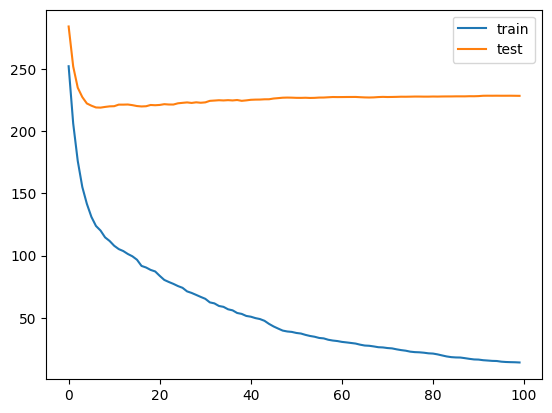

In [60]:
import sklearn
import xgboost as xgb
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import precision_score, recall_score, accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy import absolute

df = pd.read_csv("../CSVFiles/EncodedSalesListing.csv")
SelectedColumns = ["Sqr Ft", "Longitude", "Latitude", "Lot Size", "Beds", "Bath", "Year Built", "Days On Trulia",]

#data = df[SelectedColumns]
data = df.drop(columns=["Days on Market"])
labels = df['Days on Market']
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=254)


xgbRGR = xgb.XGBRegressor(verbosity=0)
print(xgbRGR.get_xgb_params())
parameters = {
     "eta"    : [0.1, 0.2, 0.25, 0.3] ,
     "max_depth"        : [2 ,3, 6, 8, 10, 15, 20],
     "min_child_weight" : [0.1, 0.5, 0.8 ,1, 7, 10 ]
    }

CV = GridSearchCV(xgbRGR, parameters,n_jobs=-1,
                    scoring="r2",
                    cv=3)
CV.fit(X_train, Y_train)
print("Multiclass Best params: ", CV.best_params_)
best = CV.best_estimator_
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(best, X_test, Y_test, scoring='r2', cv=cv, n_jobs=-1, error_score="raise")

scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

evalset = [(X_train, Y_train), (X_test, Y_test)]

xgbRGR2 = xgb.XGBRegressor(verbosity=0)
xgbRGR2.fit(X_train, Y_train, eval_set=evalset, eval_metric='rmse')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgbRGR2, X_test, Y_test, scoring='r2', cv=cv, n_jobs=-1, error_score="raise")

scores = absolute(scores)
print('Mean R: %.3f (%.3f)' % (scores.mean(), scores.std()) )
yhat = xgbRGR2.predict(X_test)
score = r2_score(Y_test, yhat)
print('Accuracy: %.3f' % score)
results = xgbRGR2.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()